In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler #Scale the demand values between 0 and 1 as LSTM needs this way


In [41]:
from google.colab import files
uploaded = files.upload()

Saving Sales_Data.csv to Sales_Data (1).csv


In [42]:
df = pd.read_csv('Sales_Data.csv')

**LSTM(TensorFlow / Keras)**

In [43]:
 # Scale demand values between 0 and 1
scaler = MinMaxScaler()
scaled_demand = scaler.fit_transform(df[['demand_quantity']])

In [44]:
# Create sequences: past 14 days → next day
sequence_length = 14
X, y = [], []

In [45]:
for i in range(sequence_length, len(scaled_demand)):
    X.append(scaled_demand[i-sequence_length:i])
    y.append(scaled_demand[i])

X, y = np.array(X), np.array(y)

In [46]:
# Train-test split (80/20), keeping time order
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (432, 14, 1) (432, 1)
Test shape: (109, 14, 1) (109, 1)


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [48]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Train the model

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2361 - val_loss: 0.0828
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0923 - val_loss: 0.0734
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0777 - val_loss: 0.0733
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0891 - val_loss: 0.0732
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0806 - val_loss: 0.0812
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0840 - val_loss: 0.0728
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0800 - val_loss: 0.0738
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0828 - val_loss: 0.0731
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0805 - val_loss: 0.0733
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0809 - val_loss: 0.0727
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0793 - val_loss: 0.0726
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0782 - 

In [50]:
# Make Predictions and Inverse Scale
Y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(Y_pred)
y_test_inv = scaler.inverse_transform(y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


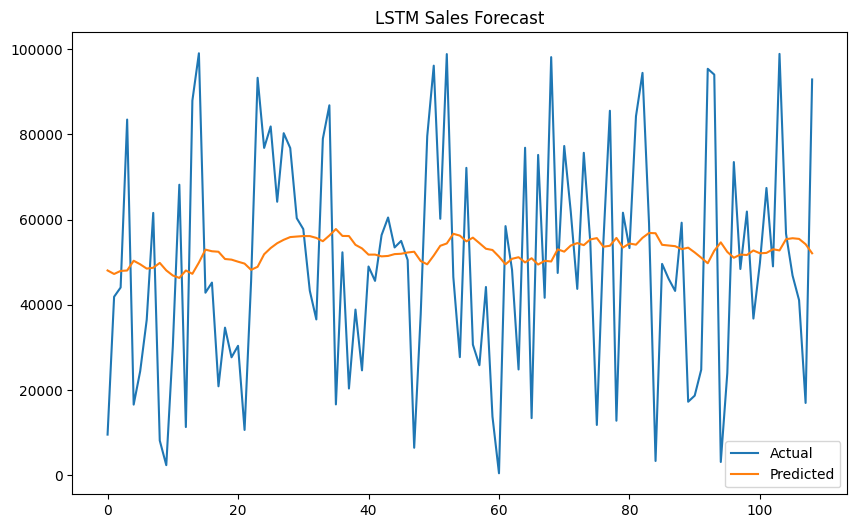

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title('LSTM Sales Forecast')
plt.show()

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lstm_mae = mean_absolute_error(y_test_inv, y_pred_inv)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
lstm_r2 = r2_score(y_test_inv, y_pred_inv)

print("LSTM Model Evaluation:")
print(f"MAE: {lstm_mae:.2f}")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"R² Score: {lstm_r2:.2f}")

LSTM Model Evaluation:
MAE: 21894.96
RMSE: 26794.89
R² Score: -0.02


In [53]:
from google.colab import files
uploaded = files.upload()

Saving prophet_result.csv to prophet_result.csv
Saving XGB_result.csv to XGB_result.csv


In [55]:
# Load Prophet and XGBoost results
prophet_df = pd.read_csv('prophet_result.csv')
xgb_df = pd.read_csv('XGB_result.csv')

In [57]:
# Your LSTM metrics (replace with actual values or variables)
lstm_df = pd.DataFrame([{
    'Model': 'LSTM',
    'MAE': lstm_mae,
    'RMSE': lstm_rmse,
    'R2': lstm_r2
}])


In [58]:
# Combine all
final_df = pd.concat([prophet_df, xgb_df, lstm_df], ignore_index=True)

# Save to Excel
final_df.to_excel('final_model_comparison.xlsx', index=False)

# Download
files.download('final_model_comparison.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
from google.colab import files
uploaded = files.upload()

Saving final_model_comparison.xlsx to final_model_comparison (1).xlsx


In [60]:
df = pd.read_excel('final_model_comparison.xlsx', engine='openpyxl')

In [61]:
df

,Model,MAE,RMSE,R2
0,Prophet,2.113149e+04,26120.258237,0.035407
1,XGB,1.941291e+09,44060.084765,-0.100719
2,LSTM,2.189496e+04,26794.888609,-0.023499
